1. This notebook can build DNN with user-defined number of layers and neurons for MNIST classification.
2. The calculation process with Matrix Notation is included in Layer Class.

# Load Data

In [1]:
import copy
import random
import numpy as np
import matplotlib.pyplot as plt
from mnist import MNIST
from math import exp,log,tanh,sqrt
mndata = MNIST('./mnist/')
mndata.gz = True
images, labels = mndata.load_training()
test_imgs, test_labels = mndata.load_testing()

# Data Preprocess

Shuffle Data

In [2]:
all_data=np.concatenate((np.array(images),np.array(labels).reshape(len(labels),1)),axis=1)
np.random.shuffle(all_data)
images=all_data[:,:-1]
labels=all_data[:,-1]

In [3]:
images=np.array(images)
transfered_images=np.zeros((len(images),784))
input_images_feature=np.zeros((len(images),785))
transfered_test_images=np.zeros((len(test_imgs),784))
input_test_images_feature=np.zeros((len(test_imgs),785))

In [4]:
# Put all values into [-1,1]
for i in range(len(images)):
    transfered_images[i]=np.array(images[i])
    transfered_images[i]=transfered_images[i]/127.5 - 1
    input_images_feature[i]=np.insert(transfered_images[i],0,1)
for i in range(len(test_imgs)):
    transfered_test_images[i]=np.array(test_imgs[i])
    transfered_test_images[i]=transfered_test_images[i]/127.5 - 1
    input_test_images_feature[i]=np.insert(transfered_test_images[i],0,1)

This is equal to randomly select since the data has been shuffled before

In [5]:
train_features=input_images_feature[:50000]
train_labels=labels[:50000]
valid_features=input_images_feature[50000:60000]
valid_labels=labels[50000:60000]
test_features=input_test_images_feature
test_labels=test_labels

# Minibatch

In [6]:
BATCH = 256

batch_train_features=[]
batch_train_labels=[]
for i in range(int(len(train_features)/BATCH)):
    batch_train_features.append(train_features[i*BATCH:i*BATCH+BATCH])
    batch_train_labels.append(train_labels[i*BATCH:i*BATCH+BATCH])
batch_train_features.append(train_features[i*BATCH+BATCH:])
batch_train_labels.append(train_labels[i*BATCH+BATCH:])

# Layer Class

In [7]:
class Layer(object):
    
    def __init__(self,num_next_layer_neuron):
        self.output_num=num_next_layer_neuron
        
    def configure(self,input_shape,reg_lam):
        self.lam = reg_lam
        self.w_shape=(input_shape[1],self.output_num)
        self.w=np.random.normal(0,1/sqrt(input_shape[0]),self.w_shape)
        self.delta_w=np.zeros(self.w_shape)
        
    def hidden_forward_prop(self,inputs,activate_index):
        self.x=copy.deepcopy(inputs)
        self.a=np.dot(self.x,self.w)
        self.activate_type=activate_index
        self.y=np.array(self.activate_func(self.a,activate_index))
        self.b=np.ones(len(inputs))
        self.output=np.c_[self.b,self.y]
        self.gradient=self.gradient_calc(self.output,activate_index)
        return self.output
    
    def hidden_back_prop(self,layer_index,next_layer_w,next_layer_delta,rate,alpha):
        if layer_index==1:
            self.delta=self.gradient*np.dot(next_layer_delta,next_layer_w.T)
        else:
            self.delta=self.gradient*np.dot(next_layer_delta[:,1:],next_layer_w.T)
            
        self.oldweight=copy.deepcopy(self.w)
        if self.delta_w.shape[1]>layer_neuron_num_list[len(layer_list)-1-layer_index]:
            self.old_delta_weight=copy.deepcopy(self.delta_w[:,1:])
        else:
            self.old_delta_weight=copy.deepcopy(self.delta_w)
            
        self.delta_w=rate*(np.dot(self.x.T,self.delta)[:,1:]/len(self.x))
        self.old_weight=copy.deepcopy(self.w)
        self.w+=alpha*self.old_delta_weight+self.delta_w
        
    def output_forward_prop(self,inputs,activate_index,label):
        self.x=copy.deepcopy(inputs)
        self.a=np.dot(self.x,self.w)
        self.label=label
        self.vector_label=np.zeros((len(inputs),self.output_num))
        for i in range(len(inputs)):
            self.vector_label[i][int(label[i])]=1
        self.activate_type=activate_index
        self.y=np.exp(self.a)/np.repeat(np.sum(np.exp(self.a),axis=1).reshape(self.a.shape[0],1),self.a.shape[1],axis=1)
        return self.y
    
    def output_back_prop(self,rate,output_y,alpha):
        self.delta=self.vector_label-output_y
        self.old_weight=copy.deepcopy(self.w)
        self.old_delta_weight=copy.deepcopy(self.delta_w)
        self.delta_w=rate*(np.dot(self.x.T,self.delta)/len(self.x) - 2*self.lam*self.w)
        self.w+=alpha*self.old_delta_weight+self.delta_w
        
    def predict(self):
        self.predicts=[0]*len(self.x)
        self.predicts=self.y.argsort()[:,-1]
        
    def accuracy(self):
        total_num=len(self.x)
        correct_num=sum([1 if self.predicts[i]==self.label[i] else 0 for i in range(total_num)])
        return correct_num/total_num
    
    def activate_func(self,a,index):
        if index==0:
            return 1/(1+np.exp(-a))
        if index==1:
            return 1.7159*np.tanh(2*a/3)
        if index==2:
            zeros=np.zeros(a.shape)
            return np.maximum(zeros,a)
        
    def gradient_calc(self,output,index):
        if index==0:
            return np.multiply((1-output),output)
        if index==1:
            return 1.7159*(2/3)*(1-(np.tanh(output))**2)
        if index==2:
            zeros=np.zeros(output.shape)
            return np.greater(output,0).astype(int)
        
    def softmax_entropy(self):
        entropy=0
        entropy-=sum(np.log(np.sum(self.y*self.vector_label,axis=1)))/self.y.shape[1]
        return entropy/(len(self.x)) + np.sum(np.square(self.w)) * self.lam

# Initialize Training

In [8]:
# Set Initial Parameter for neural network

################################################
# Set number of neurons for every layer       ##
# This also decide how the number of layers   ##
# For MNIST the last number must be 10.       ##
layer_neuron_num_list=[128,64,10]             ##
################################################

######################################
# Set update rate                   ##
output_layer_update_rate=0.00001    ##
hidden_layer_update_rate=0.01       ##
momentum_alpha=0.9                  ##
reg_lambda=0.1                      ##
######################################

###########################################################################
# Set activate function type: 0 for sigmoid, 1 for tanh and 2 for ReLU   ##
activate_type_index = 2                                                  ##
# Set nunber of data per mini-batch                                      ##
num_per_batch = BATCH                                                    ##
num_batch_per_epoch=int(len(train_features)/num_per_batch)               ##
###########################################################################

# Initial list for the layers and their output
layer_list=[]
valid_layer_list=[]
test_layer_list=[]
layer_output_list=[]
valid_layer_output_list=[]
test_layer_output_list=[]

# Save data to list
train_entropy_data=[]
train_accuracy_data=[]
valid_entropy_data=[]
valid_accuracy_data=[]
test_entropy_data=[]
test_accuracy_data=[]

# Initialize each layer
for i in range(len(layer_neuron_num_list)):
    layer_list.append(Layer(layer_neuron_num_list[i]))
    valid_layer_list.append(Layer(layer_neuron_num_list[i]))
    test_layer_list.append(Layer(layer_neuron_num_list[i]))
    if i==0:
        layer_list[i].configure((len(batch_train_features[0]),785),reg_lambda)
        valid_layer_list[i].configure((len(valid_features),785),reg_lambda)
        test_layer_list[i].configure((len(test_features),785),reg_lambda)
    else:
        layer_list[i].configure((len(batch_train_features[0]),layer_neuron_num_list[i-1]+1),reg_lambda)
        valid_layer_list[i].configure((len(batch_train_features[0]),layer_neuron_num_list[i-1]+1),reg_lambda)
        test_layer_list[i].configure((len(batch_train_features[0]),layer_neuron_num_list[i-1]+1),reg_lambda)

# Start Training

In [9]:
# Start training
saved_valid_entropy=[0,0,0]
tmp_train_entropy=[]
tmp_train_accuracy=[]

# Initial Forward Propagation
for i in range(len(layer_list)):
    valid_layer_list[i].w=copy.deepcopy(layer_list[i].w)
    test_layer_list[i].w=copy.deepcopy(layer_list[i].w)
    if i==0:
        layer_output_list.append(layer_list[i].hidden_forward_prop(batch_train_features[0],activate_type_index))
        valid_layer_output_list.append(valid_layer_list[i].hidden_forward_prop(valid_features,activate_type_index))
        test_layer_output_list.append(test_layer_list[i].hidden_forward_prop(test_features,activate_type_index))
    elif i!=len(layer_list)-1:
        layer_output_list.append(layer_list[i].hidden_forward_prop(layer_output_list[i-1],activate_type_index))
        valid_layer_output_list.append(valid_layer_list[i].hidden_forward_prop(valid_layer_output_list[i-1],activate_type_index))
        test_layer_output_list.append(test_layer_list[i].hidden_forward_prop(test_layer_output_list[i-1],activate_type_index))
    elif i==len(layer_list)-1:
        layer_output_list.append(layer_list[i].output_forward_prop(layer_output_list[i-1],activate_type_index,batch_train_labels[0]))
        valid_layer_output_list.append(valid_layer_list[i].output_forward_prop(valid_layer_output_list[i-1],activate_type_index,valid_labels))
        test_layer_output_list.append(test_layer_list[i].output_forward_prop(test_layer_output_list[i-1],activate_type_index,test_labels))

# Start Loop
count_epoch=0
print('iter\ttrain_entropy\t\tvalid_entropy\t\ttest_entropy\t\ttrain_acc\tvalid_acc\ttest_acc')

for num in range(100000000):
    
    # Backward Propagation
    for i in range(len(layer_list)):
        if i==0:
            layer_list[len(layer_list)-1].output_back_prop(output_layer_update_rate,layer_output_list[len(layer_list)-1],momentum_alpha)
        else:
            layer_list[len(layer_list)-i-1].hidden_back_prop(i,layer_list[len(layer_list)-i].old_weight,layer_list[len(layer_list)-i].delta,hidden_layer_update_rate,momentum_alpha)

    # Forward Propagation
    for i in range(len(layer_list)):
        valid_layer_list[i].w=copy.deepcopy(layer_list[i].w)
        test_layer_list[i].w=copy.deepcopy(layer_list[i].w)
        if i==0:
            layer_output_list[i]=layer_list[i].hidden_forward_prop(batch_train_features[num%num_batch_per_epoch],activate_type_index)
        elif i!=len(layer_list)-1:
            layer_output_list[i]=layer_list[i].hidden_forward_prop(layer_output_list[i-1],activate_type_index)
        elif i==len(layer_list)-1:
            layer_output_list[i]=layer_list[i].output_forward_prop(layer_output_list[i-1],activate_type_index,batch_train_labels[num%num_batch_per_epoch])
    layer_list[-1].predict()
    tmp_train_accuracy.append(layer_list[-1].accuracy())
    tmp_train_entropy.append(layer_list[-1].softmax_entropy())

    # One epoch finished
    if num%num_batch_per_epoch==0:
        count_epoch+=1
        train_accuracy=sum(tmp_train_accuracy)/len(tmp_train_accuracy)
        train_entropy=sum(tmp_train_entropy)/len(tmp_train_entropy)
        tmp_train_entropy=[]
        tmp_train_accuracy=[]

        # Forward Propagation for valid and test
        for i in range(len(layer_list)):
            valid_layer_list[i].w=copy.deepcopy(layer_list[i].w)
            test_layer_list[i].w=copy.deepcopy(layer_list[i].w)
            if i==0:
                valid_layer_output_list[i]=valid_layer_list[i].hidden_forward_prop(valid_features,activate_type_index)
                test_layer_output_list[i]=test_layer_list[i].hidden_forward_prop(test_features,activate_type_index)
            elif i!=len(layer_list)-1:
                valid_layer_output_list[i]=valid_layer_list[i].hidden_forward_prop(valid_layer_output_list[i-1],activate_type_index)
                test_layer_output_list[i]=test_layer_list[i].hidden_forward_prop(test_layer_output_list[i-1],activate_type_index)
            elif i==len(layer_list)-1:
                valid_layer_output_list[i]=valid_layer_list[i].output_forward_prop(valid_layer_output_list[i-1],activate_type_index,valid_labels)
                test_layer_output_list[i]=test_layer_list[i].output_forward_prop(test_layer_output_list[i-1],activate_type_index,test_labels)

        valid_layer_list[len(valid_layer_list)-1].predict()
        valid_accuracy=valid_layer_list[len(valid_layer_list)-1].accuracy()
        valid_entropy=valid_layer_list[len(valid_layer_list)-1].softmax_entropy()
        test_layer_list[len(test_layer_list)-1].predict()
        test_accuracy=test_layer_list[len(test_layer_list)-1].accuracy()
        test_entropy=test_layer_list[len(test_layer_list)-1].softmax_entropy()

        # Save data to list for plotting
        train_entropy_data.append(train_entropy)
        train_accuracy_data.append(train_accuracy)
        valid_entropy_data.append(valid_entropy)
        valid_accuracy_data.append(valid_accuracy)
        test_entropy_data.append(test_entropy)
        test_accuracy_data.append(test_accuracy)
        saved_valid_entropy[num%3]=valid_entropy
        
        # Print Result
        print(str(count_epoch)+'\t'+str(train_entropy)+'\t'+str(valid_entropy)+'\t'+
              str(test_entropy)+'\t'+str(train_accuracy)+'\t'+
              str(valid_accuracy)+'\t'+str(test_accuracy))

        # Shuffle train data after one epoch
        all_train_data=np.concatenate((np.array(train_features),np.array(train_labels).reshape(len(train_labels),1)),axis=1)
        np.random.shuffle(all_train_data)
        new_train_images=all_train_data[:,:-1]
        new_train_labels=all_train_data[:,-1]
        train_features=copy.deepcopy(np.array(new_train_images))
        train_labels=copy.deepcopy(np.array(new_train_labels))

        # Split mini-batch again
        batch_train_features=[]
        batch_train_labels=[]
        for i in range(int(len(train_features)/num_per_batch)):
            batch_train_features.append(train_features[i*num_per_batch:i*num_per_batch+num_per_batch])
            batch_train_labels.append(train_labels[i*num_per_batch:i*num_per_batch+num_per_batch])

iter	train_entropy		valid_entropy		test_entropy		train_acc	valid_acc	test_acc
1	0.7154980603645423	0.7172576631944949	0.717675219912451	0.1328125	0.1101	0.1053
2	0.6556505728881975	0.5999836479093041	0.5985420656951873	0.5399038461538461	0.7281	0.7389
3	0.5717433468173614	0.553214781323728	0.5517557842403331	0.7884615384615384	0.8316	0.8336
4	0.5444133176056103	0.5374353308218704	0.5357247306892783	0.8465544871794872	0.8614	0.8639
5	0.5333833916651912	0.5294035599339412	0.5279339803122501	0.8670072115384615	0.8782	0.8806
6	0.527323986556908	0.5247108295352664	0.5231940921728	0.8788261217948717	0.8881	0.8881
7	0.523341085250825	0.5215270295809175	0.5199379521714237	0.8862980769230769	0.8918	0.8946
8	0.5203624103815641	0.51895929074165	0.5175220702602438	0.8923878205128205	0.8951	0.8967
9	0.5179782736331043	0.516815930659365	0.5154145508853039	0.896113782051282	0.8993	0.9005
10	0.5160189317753721	0.5152279245913436	0.5137714592678208	0.8991786858974359	0.9003	0.9028
11	0.5142268126005426

KeyboardInterrupt: 

# Plot Result

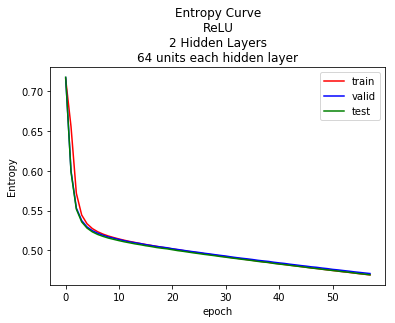

In [10]:
plt.figure()
plt.title('Entropy Curve\nReLU\n'+str(len(layer_neuron_num_list)-1)+' Hidden Layers\n'+str(layer_neuron_num_list[0])+' units each hidden layer')
plt.ylabel('Entropy')
plt.xlabel('epoch')
plt.plot(train_entropy_data,'red')
plt.plot(valid_entropy_data,'blue')
plt.plot(test_entropy_data,'green')
plt.legend(['train','valid','test'])
plt.savefig('HW3_entropy_'+str(len(layer_neuron_num_list)-1)+'_hidden_layers_'+str(layer_neuron_num_list[0])+'_neurons_per_layer')
plt.show()

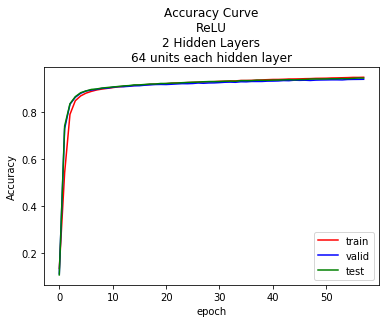

In [11]:
plt.figure()
plt.title('Accuracy Curve\nReLU\n'+str(len(layer_neuron_num_list)-1)+' Hidden Layers\n'+str(layer_neuron_num_list[0])+' units each hidden layer')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.plot(train_accuracy_data,'red')
plt.plot(valid_accuracy_data,'blue')
plt.plot(test_accuracy_data,'green')
plt.legend(['train','valid','test'])
plt.savefig('HW3_accuracy_'+str(len(layer_neuron_num_list)-1)+'_hidden_layers_'+str(layer_neuron_num_list[0])+'_neurons_per_layer')
plt.show()